# Projekt z przedmiotu Metody Klasyfikacji Danych Geoinformatycznych - Etap 2

### Analiza/klasyfikacja dowolnych obrazów za pomocą macierzy wspólnych wystąpień (Grey Level Co-occurence Matrices - GLCM)

#### Skład zespołu: Marta Dzięgielewska s176363, Maciej Gielert s176137

Link do etapu 1: https://docs.google.com/document/d/1HsTw6qhrXO0SoeWtg8hENvtkOi2oqkhV-VhOnhndA5s/edit?usp=sharing

In [6]:
# imports

import tensorflow as tf
import numpy as np
import skimage.transform
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.color import label2rgb
from skimage.util import montage as montage2d
from skimage.feature import greycomatrix, greycoprops
from tqdm import tqdm_notebook as tqdm
import cv2
%matplotlib inline

Dataset: https://www.robots.ox.ac.uk/~vgg/data/dtd/

In [2]:
# split the dataset

directory = "dtd/images"

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    image_size=(256, 256),
    shuffle=True,
    crop_to_aspect_ratio=True,
    batch_size=32,
    seed=42)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    image_size=(256, 256),
    crop_to_aspect_ratio=True,
    shuffle=True,
    seed=42)

Found 5640 files belonging to 47 classes.
Using 4512 files for training.
Found 5640 files belonging to 47 classes.
Using 1128 files for validation.


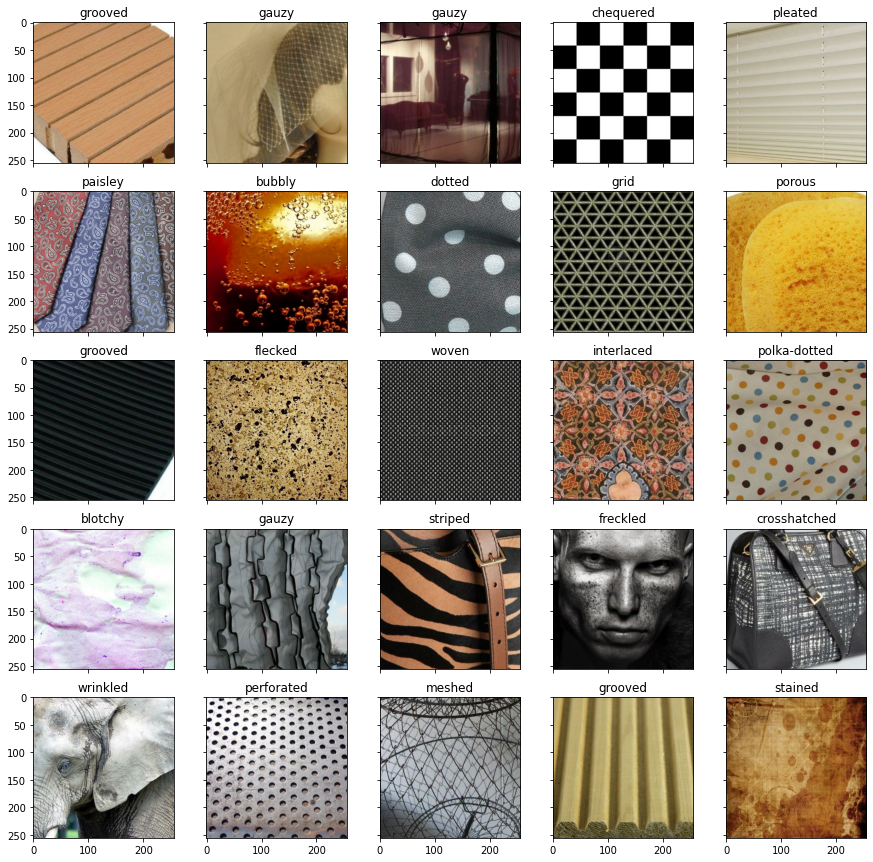

In [5]:
# example images and labels from dataset

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in train_ds.take(1):
    for i in range(5):
        for j in range(5):
            ax[i][j].imshow(images[i*5+j].numpy().astype("uint8"))
            ax[i][j].set_title(train_ds.class_names[labels[i*5+j]])
plt.show()

Text(0.5, 1.0, 'converted to gray image')

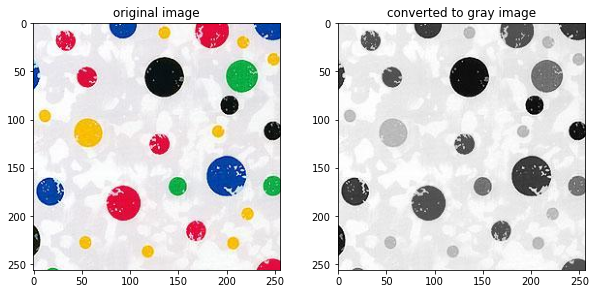

In [32]:
fig = plt.figure(figsize=(10, 10))

# load an image from dataset
img = cv2.imread('dtd/images/dotted/dotted_0109.jpg')[0:256,0:256]

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig.add_subplot(2, 2, 1)
plt.imshow(rgb_img)
plt.title("original image")

# convert to grey
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig.add_subplot(2, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.title("converted to gray image")

<AxesSubplot:>

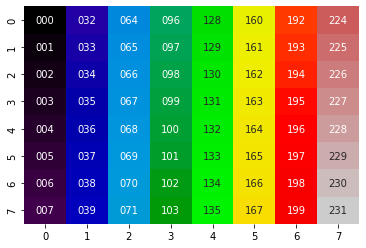

In [39]:
# divide the image up into unique tiles for further processing

mask = gray_img>0

xx, yy = np.meshgrid(
    np.arange(gray_img.shape[1]),
    np.arange(gray_img.shape[0]))

region_labels = (xx//32) * 32+yy//32
region_labels = region_labels.astype(int)

sns.heatmap(region_labels[::32, ::32].astype(int),
            annot=True,
            fmt="03d",
            cmap='nipy_spectral',
            cbar=False)

In [40]:
# compute GLCM properties each patch

grayco_prop_list = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

prop_imgs = {}
for c_prop in grayco_prop_list:
    prop_imgs[c_prop] = np.zeros_like(gray_img, dtype=np.float32)
    
score_img = np.zeros_like(gray_img, dtype=np.float32)
out_df_list = []
for patch_idx in np.unique(region_labels):
    xx_box, yy_box = np.where(region_labels == patch_idx)

    glcm = skimage.feature.graycomatrix(gray_img[xx_box.min():xx_box.max(), yy_box.min():yy_box.max()], [5], [0], 256, symmetric=True, normed=True)

    mean_score = np.mean(mask[region_labels == patch_idx])
    score_img[region_labels == patch_idx] = mean_score

    out_row = dict(
        intensity_mean=np.mean(gray_img[region_labels == patch_idx]),
        intensity_std=np.std(gray_img[region_labels == patch_idx]),
        score=mean_score)

    for c_prop in grayco_prop_list:
        out_row[c_prop] = skimage.feature.graycoprops(glcm, c_prop)[0, 0]
        prop_imgs[c_prop][region_labels == patch_idx] = out_row[c_prop]

    out_df_list += [out_row]

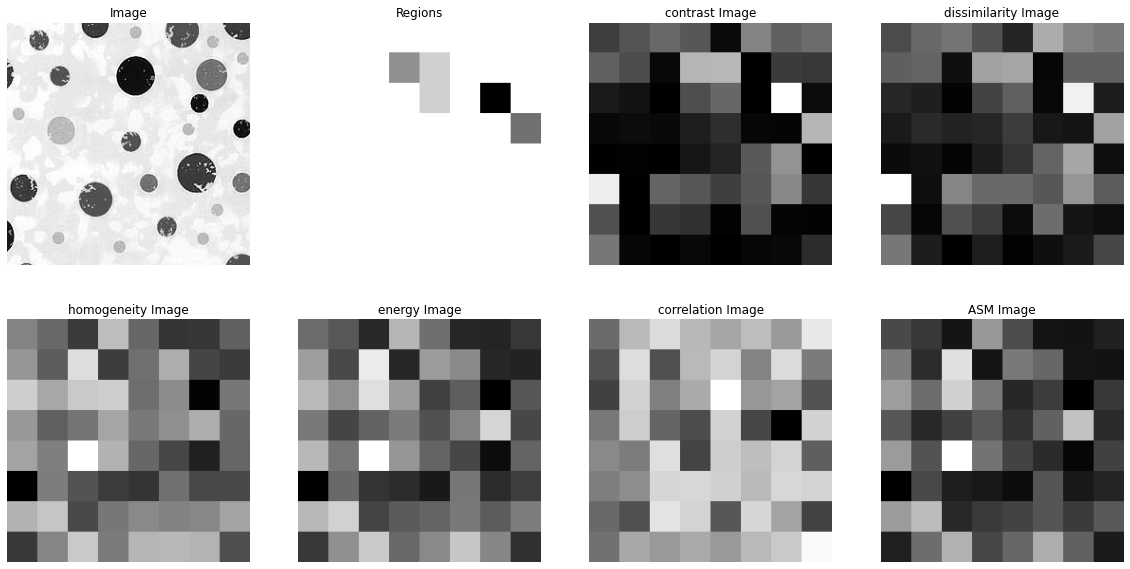

In [41]:
fig, m_axs = plt.subplots(2, 4, figsize=(20, 10))

n_axs = m_axs.flatten()
ax1 = n_axs[0]
ax2 = n_axs[1]

ax1.imshow(gray_img, cmap='gray')
ax1.set_title('Image')

ax2.imshow(score_img, cmap='gray')
ax2.set_title('Regions')
for c_ax, c_prop in zip(n_axs[2:], grayco_prop_list):
    c_ax.imshow(prop_imgs[c_prop], cmap='gray')
    c_ax.axis('off')
    c_ax.set_title('{} Image'.format(c_prop))

In [42]:
out_df = pd.DataFrame(out_df_list)
out_df['positive_score'] = out_df['score'].map(
    lambda x: 'FG' if x > 0.35 else 'BG')
out_df.describe()

,intensity_mean,intensity_std,score,contrast,dissimilarity,homogeneity,energy,correlation,ASM
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,211.938553,43.874155,0.999420,2116.849624,19.552710,0.166060,0.056388,0.473149,0.003434
std,30.899542,29.825995,0.002403,2224.926520,13.200926,0.053726,0.016073,0.202120,0.001943
min,93.625000,4.714193,0.984375,25.514888,3.760546,0.045377,0.027812,-0.094460,0.000774
25%,196.639893,16.720404,1.000000,272.186104,8.523883,0.121662,0.044143,0.326329,0.001949
50%,222.566406,46.202778,1.000000,1662.562035,17.395782,0.163398,0.054598,0.504624,0.002981
75%,233.968018,65.060147,1.000000,3218.916253,27.259615,0.208277,0.065941,0.651987,0.004348
max,246.324219,103.204647,1.000000,9292.114144,60.828784,0.296812,0.095911,0.811834,0.009199


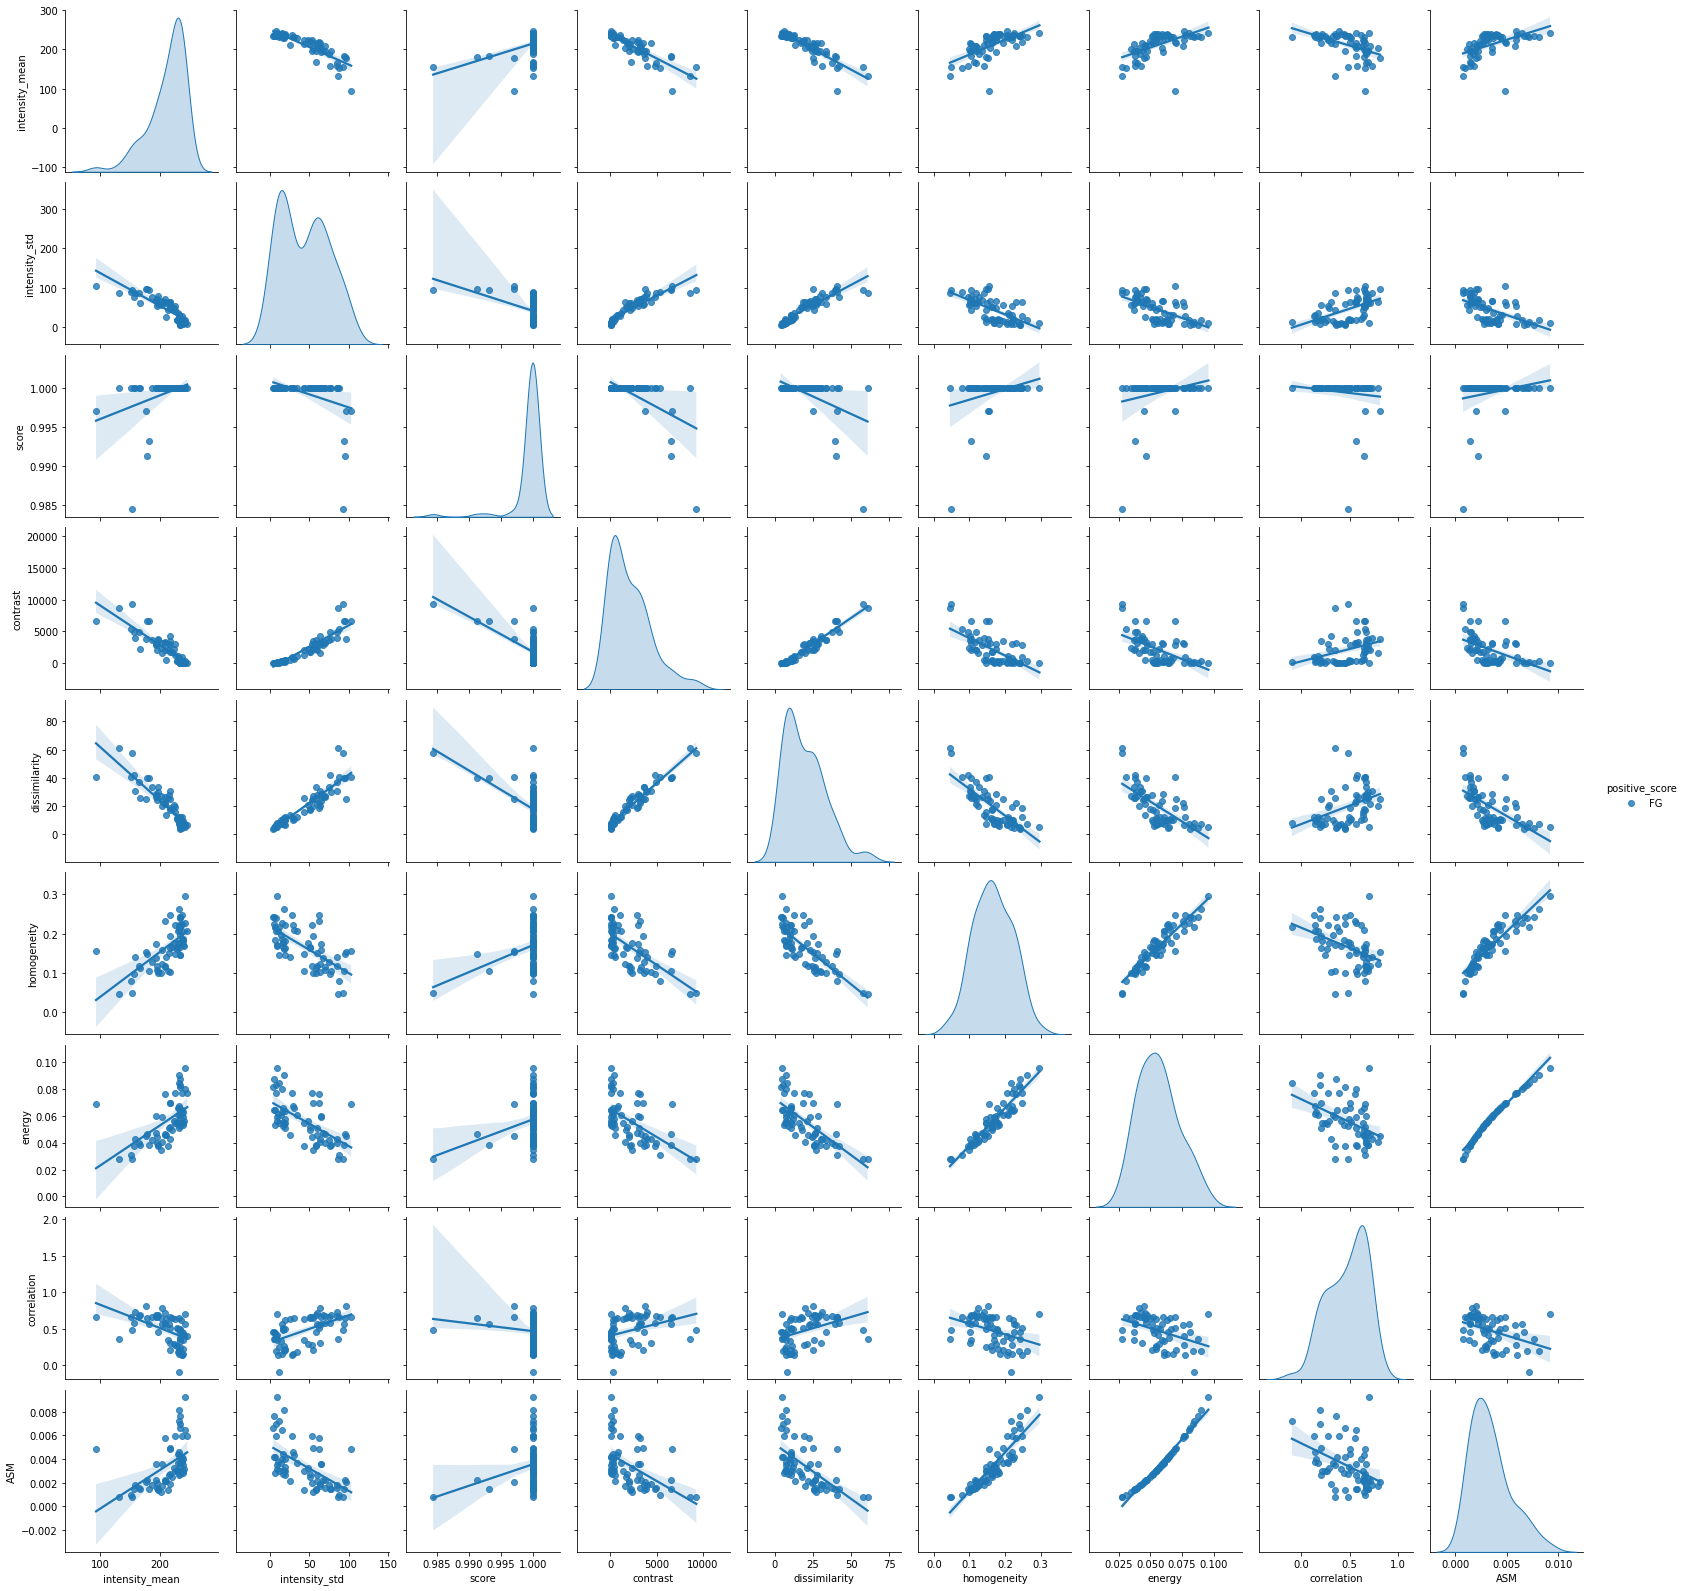

In [43]:
sns.pairplot(out_df,
             hue='positive_score',
             kind="reg")